In [83]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, \
    f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
import tensorflow as tf
from tensorflow.keras import models, layers
import seaborn as sns

In [64]:
df = pd.read_csv('dataset.csv')
df.head(10)

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART
5,Image_6.jpg,CAIRNS BIRDWING
6,Image_7.jpg,GREEN CELLED CATTLEHEART
7,Image_8.jpg,EASTERN DAPPLE WHITE
8,Image_9.jpg,BROWN SIPROETA
9,Image_10.jpg,RED POSTMAN


In [65]:
CLASSES_COUNT = 7
classes_list = df['label'].value_counts()[:CLASSES_COUNT].index.tolist()
classes_list

['MOURNING CLOAK',
 'SLEEPY ORANGE',
 'ATALA',
 'BROWN SIPROETA',
 'CRECENT',
 'SCARCE SWALLOW',
 'BANDED ORANGE HELICONIAN']

In [66]:
df = df[df['label'].isin(classes_list)]
len(df)

728

In [67]:
df['label'].nunique()

7

In [68]:
samples_cnt_by_label = df['label'].value_counts()
samples_cnt_by_label

label
MOURNING CLOAK              131
SLEEPY ORANGE               107
ATALA                       100
BROWN SIPROETA               99
SCARCE SWALLOW               97
CRECENT                      97
BANDED ORANGE HELICONIAN     97
Name: count, dtype: int64

<Axes: title={'center': 'Samples distribution by label'}, xlabel='label'>

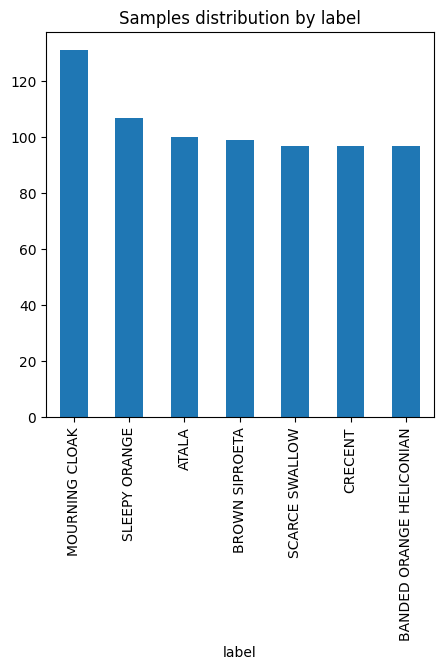

In [69]:
samples_cnt_by_label.plot.bar(x='label', y='count', figsize=(5, 5), title='Samples distribution by label')

In [70]:
def load_images(input_df, base_path=os.path.join('.', 'images')):
    images = []
    labels = []

    for i in range(len(input_df)):
        df_row = df.iloc[i]
        image_path = os.path.join(base_path, df_row['filename'])
        src_image = cv2.imread(image_path)
        images.append(cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB))
        labels.append(df_row['label'])

    return np.array(images), np.array(labels)


images, labels = load_images(df)
print(images.shape)

(728, 224, 224, 3)


In [71]:
X = images
Y = labels

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42, stratify=Y)

print(f"Train dataset size={X_train.shape[0]}")
print(f"Test dataset size={X_test.shape[0]}")

Train dataset size=582
Test dataset size=146


In [72]:
X_train, X_test = X_train / 255.0, X_test / 255.0

In [73]:
X_train[0].shape # sizes of all images are the same

(224, 224, 3)

In [74]:
def build_model():
    result_model = models.Sequential()
    result_model.add(layers.Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
    result_model.add(layers.MaxPooling2D((3, 3)))
    result_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    result_model.add(layers.MaxPooling2D((3, 3)))
    result_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    result_model.add(layers.MaxPooling2D((3, 3)))
    result_model.add(layers.Flatten())
    result_model.add(layers.Dense(64, activation='relu'))
    result_model.add(layers.Dense(CLASSES_COUNT, activation='softmax'))
    
    return result_model


model = build_model()

C:\Dev_software\python\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [75]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,543 (1006.03 KB)

 Trainable params: 257,543 (1006.03 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
def compile_and_fit_model(model, train_data, validation_data):
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train,
        Y_train,
        epochs=15,
        validation_data=validation_data
    )
    
    return history

history = compile_and_fit_model(model, (X_train, Y_train), (X_test, Y_test))

Epoch 1/15


C:\Dev_software\python\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.9765 - loss: 0.0550 - val_accuracy: 0.8493 - val_loss: 0.8085
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.9843 - loss: 0.0458 - val_accuracy: 0.8493 - val_loss: 0.5727
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.9851 - loss: 0.0376 - val_accuracy: 0.9315 - val_loss: 0.4052
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.9110 - val_loss: 0.3377
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 1.0000 - loss: 5.1703e-04 - val_accuracy: 0.9247 - val_loss: 0.3357
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 1.0000 - loss: 3.9224e-04 - val_accuracy: 0.9315 - val_loss: 0.3633
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 1.0000 - loss: 1.8344e-04 - val_accuracy: 0.9315 - val_loss: 0.3666
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 1.0000 - loss: 1.6832e-04 - val_accurac

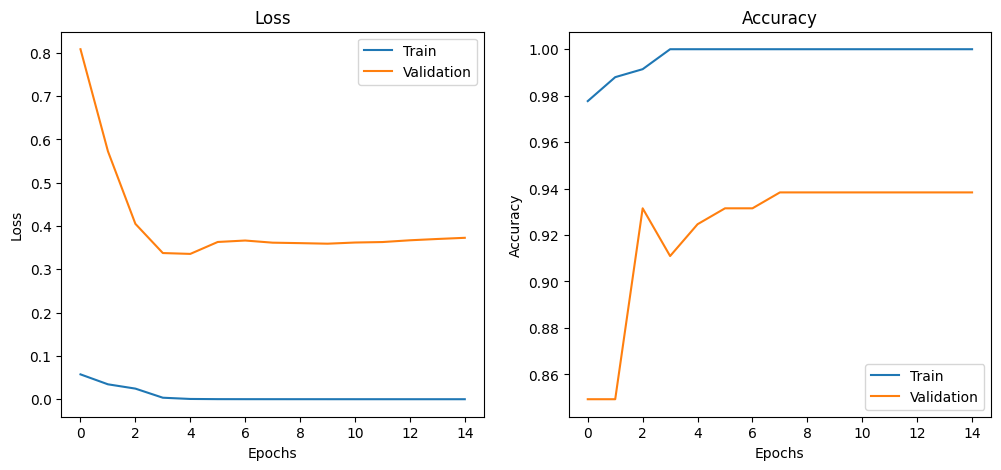

In [88]:
def plot_train_val_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    
plot_train_val_history(history)

In [89]:
def tf_predict(model, X_test):
    return np.argmax(model.predict(X_test), axis=1)


Y_pred = tf_predict(model, X_test)

conf_matrix = tf.math.confusion_matrix(
    labels=Y_test,
    predictions=Y_pred,
    num_classes=CLASSES_COUNT
)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


<Axes: >

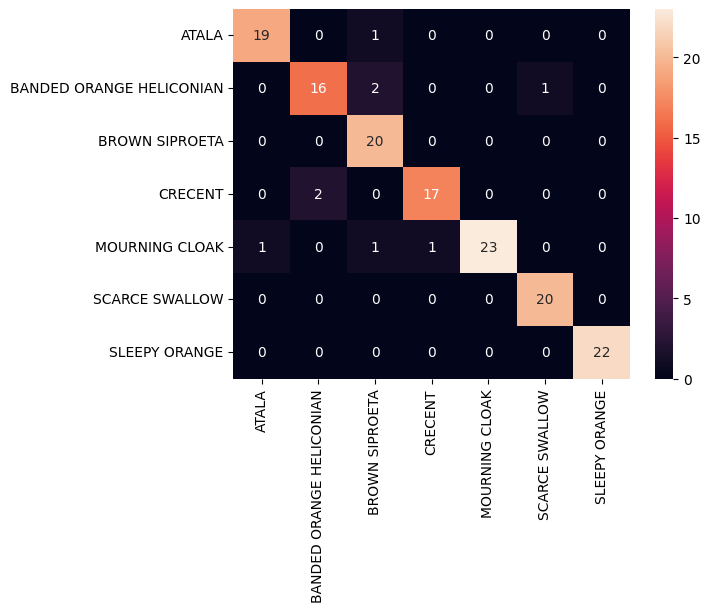

In [90]:
sns.heatmap(conf_matrix, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, annot=True)

In [91]:
Y_test_str = label_encoder.inverse_transform(Y_test)
Y_pred_str = label_encoder.inverse_transform(Y_pred)

print(classification_report(Y_test_str, Y_pred_str))

                          precision    recall  f1-score   support

                   ATALA       0.95      0.95      0.95        20
BANDED ORANGE HELICONIAN       0.89      0.84      0.86        19
          BROWN SIPROETA       0.83      1.00      0.91        20
                 CRECENT       0.94      0.89      0.92        19
          MOURNING CLOAK       1.00      0.88      0.94        26
          SCARCE SWALLOW       0.95      1.00      0.98        20
           SLEEPY ORANGE       1.00      1.00      1.00        22

                accuracy                           0.94       146
               macro avg       0.94      0.94      0.94       146
            weighted avg       0.94      0.94      0.94       146



In [86]:
def perform_cross_val(X, Y, label_encoder=label_encoder):
    skf = StratifiedKFold()
    stats = []
    
    for train_index, test_index in skf.split(X, Y):
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        Y_train_cv, Y_test_cv = Y[train_index], Y[test_index]
        
        X_train_cv, X_test_cv = X_train_cv / 255.0, X_test_cv / 255.0
        
        model = build_model()
        compile_and_fit_model(model, (X_train_cv, Y_train_cv), (X_test_cv, Y_test_cv))
        Y_pred_cv = tf_predict(model, X_test_cv)
        
        results = {
            'accuracy': accuracy_score(Y_test_cv, Y_pred_cv),
            'precision': precision_score(Y_test_cv, Y_pred_cv, average='weighted'),
            'recall': recall_score(Y_test_cv, Y_pred_cv, average='weighted'),
            'f1': f1_score(Y_test_cv, Y_pred_cv, average='weighted'),
        }
    
        stats.append(results)
    
    return stats

print("Cross-validation results:")
print(perform_cross_val(X, Y))

Cross-validation results:


C:\Dev_software\python\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


C:\Dev_software\python\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.2633 - loss: 1.8654 - val_accuracy: 0.5685 - val_loss: 1.2165
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.5022 - loss: 1.2742 - val_accuracy: 0.7534 - val_loss: 0.8516
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.7112 - loss: 0.8139 - val_accuracy: 0.8425 - val_loss: 0.4605
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.8291 - loss: 0.4767 - val_accuracy: 0.7808 - val_loss: 0.6451
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.8181 - loss: 0.4920 - val_accuracy: 0.8767 - val_loss: 0.3727
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.8834 - loss: 0.3061 - val_accuracy: 0.9247 - val_loss: 0.2817
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.9531 - loss: 0.1928 - val_accuracy: 0.9315 - val_loss: 0.2420
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.9422 - loss: 0.1871 - val_accuracy: 0.9384 - val_

C:\Dev_software\python\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


C:\Dev_software\python\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.2313 - loss: 1.9336 - val_accuracy: 0.4589 - val_loss: 1.5649
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.5473 - loss: 1.3069 - val_accuracy: 0.7808 - val_loss: 0.7232
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.7748 - loss: 0.5954 - val_accuracy: 0.8151 - val_loss: 0.4929
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.7870 - loss: 0.5726 - val_accuracy: 0.8082 - val_loss: 0.4441
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.8819 - loss: 0.4070 - val_accuracy: 0.9178 - val_loss: 0.2779
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.9008 - loss: 0.2569 - val_accuracy: 0.9041 - val_loss: 0.2838
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.9352 - loss: 0.1933 - val_accuracy: 0.9452 - val_loss: 0.2067
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.9619 - loss: 0.1438 - val_accuracy: 0.9452 - val_

C:\Dev_software\python\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


C:\Dev_software\python\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.2239 - loss: 1.9139 - val_accuracy: 0.5274 - val_loss: 1.3611
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.5935 - loss: 1.1962 - val_accuracy: 0.5959 - val_loss: 1.0835
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.7062 - loss: 0.8855 - val_accuracy: 0.8767 - val_loss: 0.4717
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.8156 - loss: 0.5317 - val_accuracy: 0.9178 - val_loss: 0.2710
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.8617 - loss: 0.3515 - val_accuracy: 0.9247 - val_loss: 0.2140
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.9054 - loss: 0.2579 - val_accuracy: 0.9452 - val_loss: 0.1534
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.9434 - loss: 0.1746 - val_accuracy: 0.9521 - val_loss: 0.1235
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.9161 - loss: 0.2355 - val_accuracy: 0.9110 - val_

C:\Dev_software\python\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


C:\Dev_software\python\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.2607 - loss: 1.8284 - val_accuracy: 0.4138 - val_loss: 1.3858
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.5825 - loss: 1.0866 - val_accuracy: 0.7793 - val_loss: 0.6676
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.7531 - loss: 0.7063 - val_accuracy: 0.8000 - val_loss: 0.5185
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.8408 - loss: 0.4695 - val_accuracy: 0.8552 - val_loss: 0.3412
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.8875 - loss: 0.2970 - val_accuracy: 0.9172 - val_loss: 0.3031
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.9173 - loss: 0.2443 - val_accuracy: 0.9724 - val_loss: 0.1307
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.9444 - loss: 0.1573 - val_accuracy: 0.9586 - val_loss: 0.1090
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.9569 - loss: 0.1411 - val_accuracy: 0.9172 - val_

C:\Dev_software\python\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


C:\Dev_software\python\lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.2506 - loss: 1.8656 - val_accuracy: 0.3448 - val_loss: 1.6244
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.5577 - loss: 1.2370 - val_accuracy: 0.7448 - val_loss: 0.7297
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.6801 - loss: 0.7639 - val_accuracy: 0.7448 - val_loss: 0.6486
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.7741 - loss: 0.5719 - val_accuracy: 0.8276 - val_loss: 0.4923
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.8486 - loss: 0.4039 - val_accuracy: 0.9241 - val_loss: 0.2474
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.9141 - loss: 0.2559 - val_accuracy: 0.9448 - val_loss: 0.1845
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.9428 - loss: 0.1850 - val_accuracy: 0.9862 - val_loss: 0.0984
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.9754 - loss: 0.1056 - val_accuracy: 0.9655 - val_